In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

import pymorphy2

import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler

from gensim.models import Word2Vec
from gensim import corpora

In [2]:
DATAFRAME_SIZE = 5000

In [3]:
data = pd.read_csv("dictionary_documents/text_rating_final.csv", delimiter=";", 
                   header=None, index_col=False, usecols=[0,1])
data = data.rename(columns = {0: "text", 1: "rating"})
data.dropna(inplace=True)
data = data[data['rating'] != ' совершенный']
data['rating'] = data['rating'].astype("Int8")

In [4]:
data.head(5)

,text,rating
0,"Не рациональная системность, а интуитивный поз...",0
1,"Когда возникнут трудности, они тебе не помогут...",0
2,Кривая национализация это политический компром...,-1
3,Такой вид биологического оружия не действует н...,-2
4,В Эль-Кусейре /к западу от Хомса/ сирийские по...,0


In [5]:
x_train, x_test, y_train, y_test = train_test_split(data['text'].iloc[:DATAFRAME_SIZE], data['rating'][:DATAFRAME_SIZE], test_size=0.15)

In [6]:
stopwords = stopwords.words("russian")
stopwords.append("хотя")
def tokenize(string):
    morph = pymorphy2.MorphAnalyzer()
    tokens = RegexpTokenizer(r'\w+').tokenize(string)
    tokens = [word.lower() for word in tokens]
    tokens = [morph.parse(word)[0].normal_form for word in tokens if word not in stopwords]
    return tokens


dictionary = corpora.Dictionary(texts)
print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts] 

In [7]:

words = data['text'].iloc[:DATAFRAME_SIZE].apply(tokenize)

model = Word2Vec(words, vector_size=100, window=5, min_count=1, workers=4)


In [8]:
min_text_len = min(words.apply(lambda x: len(x)))
min_text_len

1

In [9]:
texts_vec = words.apply(lambda x: np.array([model.wv[word] for word in x[:min_text_len]]).flatten())

In [10]:
texts_vec

0       [-0.14240888, 0.1032877, 0.10725801, -0.035282...
1       [-0.7073613, 0.36703652, 0.37928185, -0.166437...
2       [-0.049675565, 0.06647608, 0.082118005, 0.0163...
3       [-0.8636363, 0.63454586, 0.39170438, -0.504366...
4       [0.5103069, 0.6620866, 0.2946358, 0.47766864, ...
                              ...                        
5060    [-0.20513567, 0.26451427, 0.15334693, -0.07629...
5061    [-0.23628291, 0.4651627, 0.30830526, 0.0400724...
5062    [-1.7998368, 0.64708793, 1.0831647, -0.3659704...
5063    [-0.9765456, 0.37701946, 0.5551496, -0.5954423...
5064    [0.10557134, 0.34285146, 0.8978536, 0.58991903...
Name: text, Length: 5000, dtype: object

In [11]:
w2v_x_train, w2v_x_test, w2v_y_train, w2v_y_test = train_test_split(texts_vec, data['rating'][:DATAFRAME_SIZE], test_size=0.15)
w2v_x_train, w2v_x_test = np.vstack(w2v_x_train), np.vstack(w2v_x_test)

In [14]:
classifiers = {"Наивный байесовский классификатор": MultinomialNB(), "Метод опорных векторов":SGDClassifier(), 
               "Дерево решений": DecisionTreeClassifier(), "Ансамблевый метод(Бустинг)": GradientBoostingClassifier()}
vectorizers = {"Мешок слов": CountVectorizer(lowercase=True, stop_words=stopwords), 
               "TF-IDF": TfidfVectorizer(lowercase=True, stop_words=stopwords)}
scores = {}
scaler = MinMaxScaler()
for v_name, vectorizer in vectorizers.items():
    train_transformed = vectorizer.fit_transform(x_train)
    test_transformed = vectorizer.transform(x_test)
    scores[v_name] = {}
    for c_name, classifier in classifiers.items():
        classifier.fit(train_transformed, y_train)
        predicted = classifier.predict(test_transformed)
        score = (predicted == y_test).sum()/len(predicted)
        scores[v_name][c_name] = score
        print(f"Метод векторизации - {v_name}. Классификатор - {c_name}, Score - {score}")
scores["Word2Vec"] = {}
for c_name, classifier in classifiers.items():
    if c_name == "Наивный байесовский классификатор":
        classifier.fit(scaler.fit_transform(w2v_x_train), w2v_y_train)
        predicted = classifier.predict(scaler.transform(w2v_x_test))
    else:
        classifier.fit(w2v_x_train, w2v_y_train)
        predicted = classifier.predict(w2v_x_test)
    score = (predicted == w2v_y_test).sum()/len(predicted)
    scores['Word2Vec'][c_name] = score
    print(f"Метод векторизации - Word2Vec. Классификатор - {c_name}, Score - {score}")
print(scores)

Метод векторизации - Мешок слов. Классификатор - Наивный байесовский классификатор, Score - 0.384
Метод векторизации - Мешок слов. Классификатор - Метод опорных векторов, Score - 0.36933333333333335
Метод векторизации - Мешок слов. Классификатор - Дерево решений, Score - 0.37466666666666665
Метод векторизации - Мешок слов. Классификатор - Ансамблевый метод(Бустинг), Score - 0.44266666666666665
Метод векторизации - TF-IDF. Классификатор - Наивный байесовский классификатор, Score - 0.4666666666666667
Метод векторизации - TF-IDF. Классификатор - Метод опорных векторов, Score - 0.3933333333333333
Метод векторизации - TF-IDF. Классификатор - Дерево решений, Score - 0.36933333333333335
Метод векторизации - TF-IDF. Классификатор - Ансамблевый метод(Бустинг), Score - 0.428
Метод векторизации - Word2Vec. Классификатор - Наивный байесовский классификатор, Score - 0.43333333333333335
Метод векторизации - Word2Vec. Классификатор - Метод опорных векторов, Score - 0.404
Метод векторизации - Word2Vec

C:\Users\admin\AppData\Local\Temp\ipykernel_12108\3470188130.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(names)


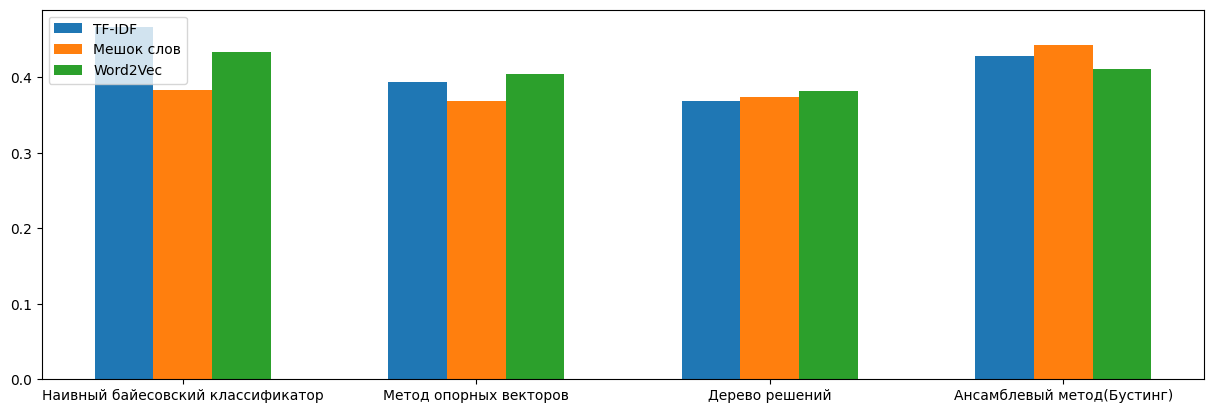

In [15]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
a = np.arange(len(scores['TF-IDF']))
width = 0.2

names = classifiers.keys()

ax.bar(a - width, scores['TF-IDF'].values(), label = 'TF-IDF', width=width)
ax.bar(a, scores['Мешок слов'].values(), label = 'Мешок слов', width=width)
ax.bar(a + width, scores['Word2Vec'].values(), label = 'Word2Vec', width=width)
ax.set_xticklabels(names)
ax.set_xticks(a)
ax.legend()

Тональный словарь

In [16]:
dictionary = pd.read_csv("dictionary_documents/words_all_full_rating.csv", delimiter=";", encoding = "Windows-1251")
dictionary.head(5)
dictionary.set_index("Words", inplace=True)

In [17]:
def get_average_rate(tokens):
    s = 0
    i = 0
    for word in tokens:
        try:
            s += dictionary.loc[word]['average rate']
            
            i += 1
        except:
            pass
    return round(s/i)

In [18]:
get_average_rate(words.iloc[0])

0

In [19]:
predicted = words.apply(get_average_rate)

In [30]:
(data['rating'][:DATAFRAME_SIZE] == 0).count()

5000

In [32]:
data[:DATAFRAME_SIZE].loc[data['rating'] == 0].count()

text      2099
rating    2099
dtype: int64

In [20]:
(predicted == data['rating'][:DATAFRAME_SIZE]).sum()/len(predicted)

0.4202

In [21]:
data['rating']

0         0
1         0
2        -1
3        -2
4         0
         ..
32432     0
32433    -2
32434    -1
32435    -2
32436     0
Name: rating, Length: 32249, dtype: Int8